### Etivity 2: Exploratory Data Analysis and Data Preparation
#### Student: Christos Koutsiaris

#### Task 1: Data Preparation Pipeline

In [26]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# 1. This converts a 'day' column into two columns using sine and cosine.
class CyclicalDayTransformer(BaseEstimator, TransformerMixin):
    """
    This transformer takes a 'day' column (values ranging from 1 to 31)
    and converts it into two cyclical features: sin(day) and cos(day).
    """

    def __init__(self, max_day=31):
        self.max_day = max_day
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            day_values = X.iloc[:, 0].values.astype(float)
        else:
            day_values = X[:, 0].astype(float)

        # Convert each day to two values (sine and cosine) based on its position in the cycle.
        day_sin = np.sin(2 * np.pi * day_values / self.max_day)
        day_cos = np.cos(2 * np.pi * day_values / self.max_day)

        # Return a 2-column array: first sin, then cos.
        return np.column_stack((day_sin, day_cos))

# 2. Load dataset
df = pd.read_csv("bank.csv")

# 3. Remove columns that can influence clustering
df.drop(columns=["subscribed", "duration"], errors="ignore", inplace=True)

# 4. Figure out which columns are numeric and which are categorical.
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

# If there is a 'day' column in numeric_cols, we separate it out so we can handle it differently.
if "day" in numeric_cols:
    numeric_cols.remove("day")

# 5. Separate pipelines for numeric, cyclical, and categorical data.

# 5a. Numeric data pipeline
numeric_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# 5b. Day column pipeline
day_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("cyclical", CyclicalDayTransformer(max_day=31))
])

# 5c. Categorical data pipeline
categorical_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 6. Combine pipelines into one ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("day", day_transformer, ["day"]),
    ("cat", categorical_transformer, categorical_cols)
], remainder="drop")

# 7. Build the final pipeline that does all the preprocessing
pipeline = Pipeline([
    ("preprocessor", preprocessor)
])

# 8. Apply pipeline to the data.
prepared_data = pipeline.fit_transform(df)

# 9. Print some details about the processed data.
print("Prepared data shape:", prepared_data.shape)
print("Number of NaNs after pipeline:", np.isnan(prepared_data).sum())


Prepared data shape: (2000, 47)
Number of NaNs after pipeline: 0


#### Task 2: k-Means

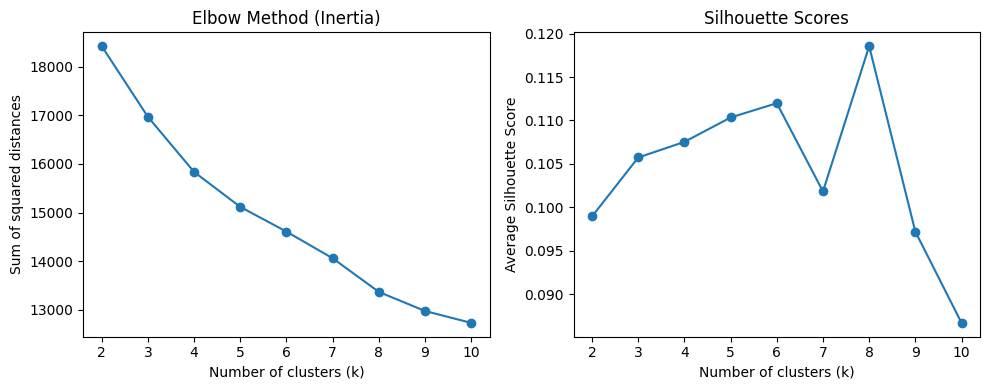

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# We will calculate two metrics to decide how many clusters might be best:
# 1) The Elbow method
# 2) The Silhouette Score

sse = []  # This stores the Sum of Squared Errors for each k
silhouette_scores = []  # This stores the Silhouette Score for each k

# Try k from 2 to 10 to see which value fits best
K_range = range(2, 11)

# Loop through each potential k value
for k in K_range:
    # Create a KMeans model using k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit the model and get the cluster assignments
    labels = kmeans.fit_predict(prepared_data)
    
    # The inertia_ attribute shows how well the data is clustered
    # It is used in the Elbow method
    sse.append(kmeans.inertia_)
    
    # The Silhouette Score measures how well-separated the clusters are.
    # Higher scores mean better-defined clusters.
    score = silhouette_score(prepared_data, labels)
    silhouette_scores.append(score)

# Plot results side by side to compare.

plt.figure(figsize=(10, 4))

# Left plot: Elbow method using Sum of Squared Distances
plt.subplot(1, 2, 1)
plt.plot(K_range, sse, marker="o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of squared distances")

# Right plot: Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker="o")
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average Silhouette Score")

plt.tight_layout()
plt.show()


In [38]:
# Suppose from the elbow & silhouette, we pick best_k
best_k = 8

kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(prepared_data)

# Attach cluster labels back to your original DataFrame
df["cluster_kmeans"] = cluster_labels
print(df["cluster_kmeans"].value_counts())


cluster_kmeans
1    610
2    423
5    350
3    301
4    159
0    149
7      7
6      1
Name: count, dtype: int64


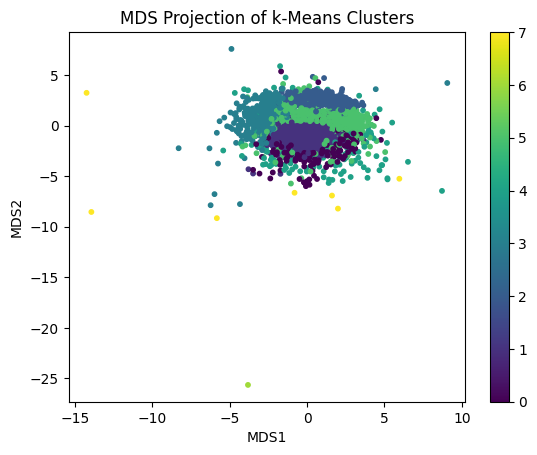

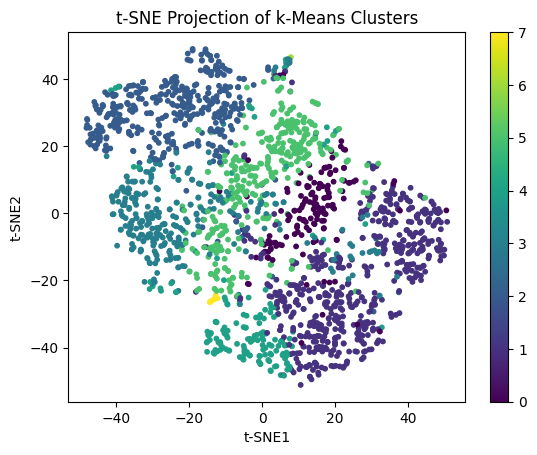

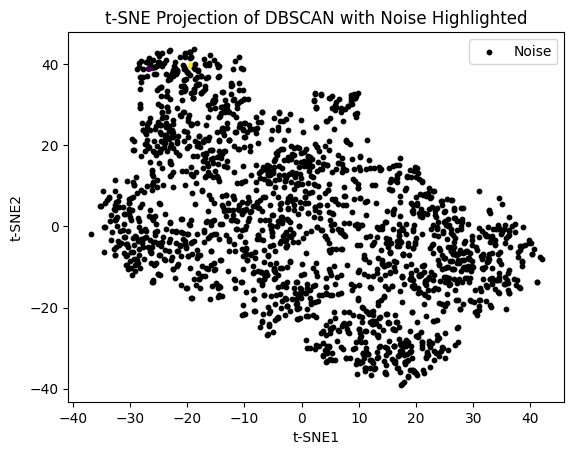

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS, TSNE

# --- MDS ---
# n_init controls the number of random initializations
mds = MDS(n_components=2, random_state=42, n_init=4)
mds_coords = mds.fit_transform(prepared_data)

plt.figure()
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], c=cluster_labels, s=10)
plt.title("MDS Projection of k-Means Clusters")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.colorbar()
plt.show()

# --- t-SNE ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, init='pca')

X_for_tsne = prepared_data.toarray() if hasattr(prepared_data, 'toarray') else prepared_data
tsne_coords = tsne.fit_transform(X_for_tsne)

plt.figure()
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], c=cluster_labels, s=10)
plt.title("t-SNE Projection of k-Means Clusters")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar()
plt.show()


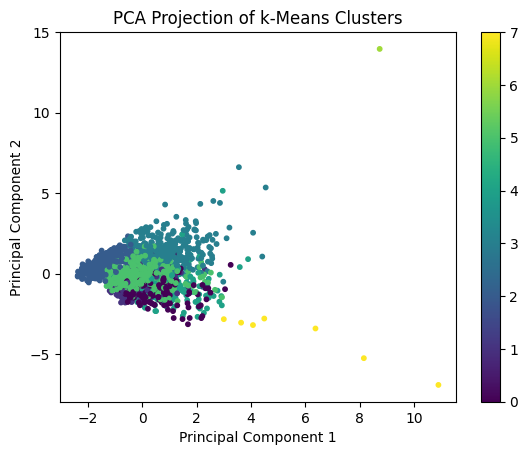

In [42]:
from sklearn.decomposition import PCA

# Trying also PCA mostly out of curiosity
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(prepared_data.toarray() if hasattr(prepared_data, 'toarray') else prepared_data)

# Plot PCA result
plt.figure()
plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c=cluster_labels, s=10)
plt.title("PCA Projection of k-Means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()


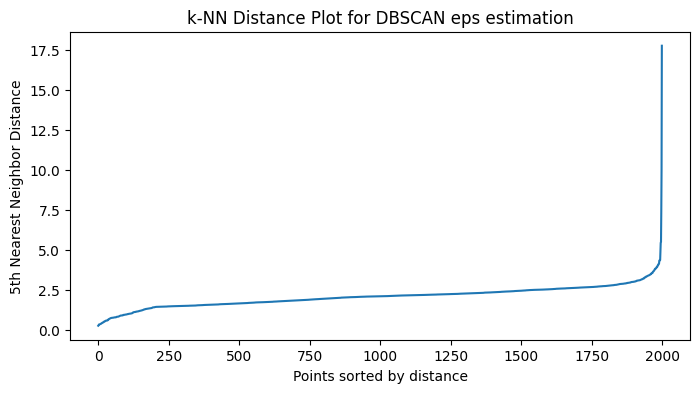

eps=0.02, min_samples=3 => #clusters=0 (insufficient for silhouette)
eps=0.02, min_samples=5 => #clusters=0 (insufficient for silhouette)
eps=0.02, min_samples=7 => #clusters=0 (insufficient for silhouette)
eps=0.039999999999999994, min_samples=3 => #clusters=0 (insufficient for silhouette)
eps=0.039999999999999994, min_samples=5 => #clusters=0 (insufficient for silhouette)
eps=0.039999999999999994, min_samples=7 => #clusters=0 (insufficient for silhouette)
eps=0.06, min_samples=3 => #clusters=0 (insufficient for silhouette)
eps=0.06, min_samples=5 => #clusters=0 (insufficient for silhouette)
eps=0.06, min_samples=7 => #clusters=0 (insufficient for silhouette)
eps=0.07999999999999999, min_samples=3 => #clusters=0 (insufficient for silhouette)
eps=0.07999999999999999, min_samples=5 => #clusters=0 (insufficient for silhouette)
eps=0.07999999999999999, min_samples=7 => #clusters=0 (insufficient for silhouette)
eps=0.09999999999999999, min_samples=3 => #clusters=0 (insufficient for silhoue

In [54]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# reducing to fewer dimensions
pca = PCA(n_components=10)
reduced_data = pca.fit_transform(prepared_data.toarray() if hasattr(prepared_data, 'toarray') else prepared_data)

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(prepared_data)
distances, indices = neighbors_fit.kneighbors(prepared_data)

# Sort distances to see the "elbow"
distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('k-NN Distance Plot for DBSCAN eps estimation')
plt.xlabel('Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.show()

# Explore DBSCAN parameters
eps_values = np.linspace(0.02, 0.3, 15)
min_samples_values = [3, 5, 7]

best_silhouette = -1
best_params = (None, None)

for eps in eps_values:
    for minsamp in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=minsamp)
        labels_tmp = db.fit_predict(prepared_data)
        
        # If DBSCAN finds fewer than 2 clusters, silhouette_score isn't meaningful!!!!!
        clusters_tmp = set(labels_tmp)
        if -1 in clusters_tmp:
            clusters_tmp.remove(-1)
        
        if len(clusters_tmp) > 1:
            sil = silhouette_score(prepared_data, labels_tmp)
            print(f"eps={eps}, min_samples={minsamp} => #clusters={len(clusters_tmp)}, silhouette={sil:.3f}")
            if sil > best_silhouette:
                best_silhouette = sil
                best_params = (eps, minsamp)
        else:
            print(f"eps={eps}, min_samples={minsamp} => #clusters={len(clusters_tmp)} (insufficient for silhouette)")

print()
print(f"Best Silhouette Score: {best_silhouette:.3f} with eps={best_params[0]} and min_samples={best_params[1]}")

# Use the best parameters to finalize DBSCAN
final_eps, final_min_samples = best_params
dbscan = DBSCAN(eps=final_eps, min_samples=final_min_samples)
labels_dbscan = dbscan.fit_predict(prepared_data)

# 3. Results
unique_labels = np.unique(labels_dbscan)
n_clusters = len(unique_labels[unique_labels != -1])  # exclude noise label (-1)
print(f"\nFinal DBSCAN using eps={final_eps}, min_samples={final_min_samples}")
print(f"Estimated number of clusters: {n_clusters}")
print("Cluster label frequencies:")
print(pd.Series(labels_dbscan).value_counts())


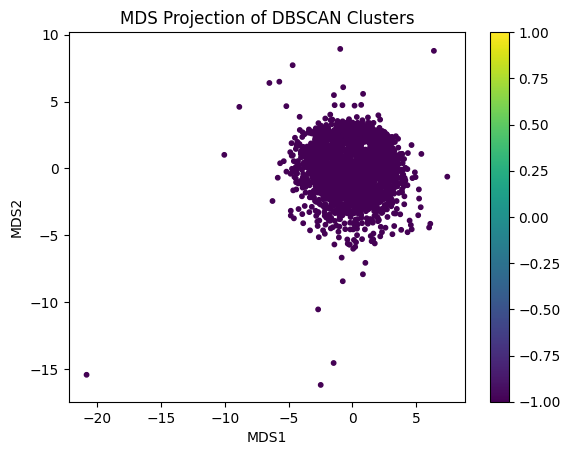

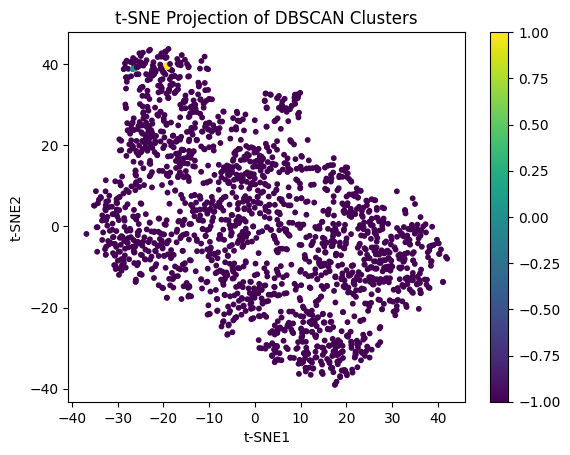

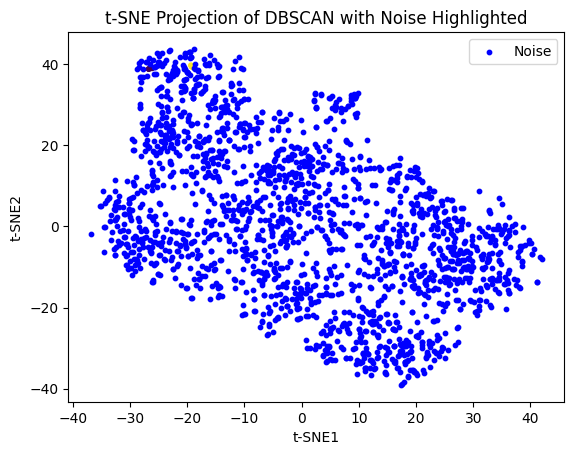

In [56]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS, TSNE

# --- MDS for DBSCAN ---
mds_for_dbscan = MDS(
    n_components=2,
    random_state=42,
    n_init=4,
    max_iter=1000
)
mds_coords_dbscan = mds_for_dbscan.fit_transform(prepared_data)

plt.figure()
plt.scatter(mds_coords_dbscan[:, 0], mds_coords_dbscan[:, 1], c=labels_dbscan, s=10)
plt.title("MDS Projection of DBSCAN Clusters")
plt.xlabel("MDS1")
plt.ylabel("MDS2")

plt.colorbar()
plt.show()

# --- t-SNE for DBSCAN ---
tsne_for_dbscan = TSNE(
    n_components=2,
    random_state=42,
    perplexity=50, 
    max_iter=1000,
    init='pca'
)

# If data is sparse, convert to denser
X_for_tsne_dbscan = prepared_data.toarray() if hasattr(prepared_data, 'toarray') else prepared_data

tsne_coords_dbscan = tsne_for_dbscan.fit_transform(X_for_tsne_dbscan)

plt.figure()
plt.scatter(tsne_coords_dbscan[:, 0], tsne_coords_dbscan[:, 1], c=labels_dbscan, s=10)
plt.title("t-SNE Projection of DBSCAN Clusters")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")

plt.colorbar()
plt.show()

# Noise points in blue
noise = labels_dbscan == -1

plt.figure()
plt.scatter(tsne_coords_dbscan[~noise, 0], tsne_coords_dbscan[~noise, 1], c=labels_dbscan[~noise], s=10)
plt.scatter(tsne_coords_dbscan[noise, 0], tsne_coords_dbscan[noise, 1], color='blue', s=10, label='Noise')

plt.legend()
plt.title("t-SNE Projection of DBSCAN with Noise Highlighted")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.show()

